# **Predicting weapon from US Murder Accountability data**

By Nrupaja Vartak and Alondra Zavala

## **Introduction**

We will examine the data on murder accountability in the United States from 1976 to 2020. We will utilize several visualizations to analyze a dataset of homicides that have occurred in the United States and predict the weapon used in the murder with the use of various machine learning algorithms. 

This dataset includes information such as the year and state of incidence, the victim and offender's age, gender, race, the weapon used, relationship, and much more. The Murder Accountability Project has created it. Our dataset is dated November 30, 2021.

Using the state, the offender's age, and their relationship to the victim, we hope to predict the weapon used in the homicide.

Imports and reading of the data set

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from scipy.stats import zscore
import warnings

In [100]:
#Disabling the warnings
warnings.filterwarnings('ignore')

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
data_dir = "/content/drive/My Drive/MurderAcc.csv"
df = pd.read_csv(data_dir)

## **Data Exploration**

In [103]:
df.shape

(521937, 31)

The original dataset contains a total of 827219 rows and 31 columns.

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521937 entries, 0 to 521936
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            521937 non-null  object 
 1   CNTYFIPS      521937 non-null  object 
 2   Ori           521937 non-null  object 
 3   State         521937 non-null  object 
 4   Agency        521937 non-null  object 
 5   Agentype      521937 non-null  object 
 6   Source        521937 non-null  object 
 7   Solved        521937 non-null  object 
 8   Year          521937 non-null  int64  
 9   StateName     14006 non-null   object 
 10  Month         521937 non-null  object 
 11  Incident      521937 non-null  int64  
 12  ActionType    521937 non-null  object 
 13  Homicide      521937 non-null  object 
 14  Situation     521937 non-null  object 
 15  VicAge        521937 non-null  int64  
 16  VicSex        521937 non-null  object 
 17  VicRace       521937 non-null  object 
 18  VicE

Since the dataset is very larget, we take a random sample from the dataset.

In [105]:
df = df.sample(frac=0.1, random_state=1)
df.shape

(52194, 31)

In [106]:
df.describe()

,Year,Incident,VicAge,OffAge,VicCount,OffCount,FileDate
count,52194.000000,52194.000000,52194.000000,52194.000000,52194.000000,52194.000000,52032.000000
mean,1996.587922,25.585029,42.545082,32.050216,0.141012,0.229586,52307.901464
std,13.199921,106.951821,94.835721,12.726038,0.602242,0.662703,32680.447642
min,1976.000000,0.000000,0.000000,17.000000,0.000000,0.000000,10181.000000
25%,1985.000000,1.000000,22.000000,22.000000,0.000000,0.000000,30116.000000
50%,1995.000000,2.000000,30.000000,29.000000,0.000000,0.000000,40490.000000
75%,2008.000000,7.000000,43.000000,38.000000,0.000000,0.000000,82295.000000
max,2020.000000,999.000000,999.000000,99.000000,10.000000,10.000000,123197.000000


Checking the total number of NA values in the dataset.

In [107]:
(df.isna().sum().sum())


100381

In [108]:
print(df['Weapon'].value_counts())

Handgun - pistol, revolver, etc         24295
Knife or cutting instrument              8844
Personal weapons, includes beating       3657
Firearm, type not stated                 3369
Shotgun                                  2970
Other or type unknown                    2390
Rifle                                    2369
Blunt object - hammer, club, etc         2299
Strangulation - hanging                   522
Fire                                      486
Asphyxiation - includes death by gas      363
Narcotics or drugs, sleeping pills        233
Other gun                                 156
Drowning                                  129
Poison - does not include gas              49
Explosives                                 43
Pushed or thrown out window                20
Name: Weapon, dtype: int64


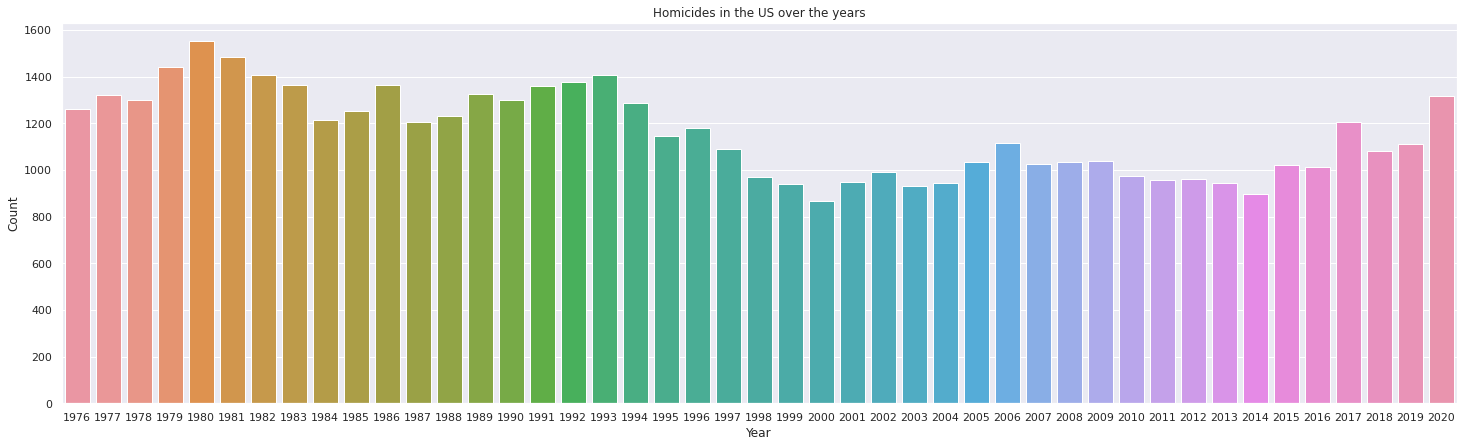

In [109]:
df['Year'] = df['Year'].apply(np.int64)
sns.set(rc = {'figure.figsize':(25, 7)})
sns.countplot(df['Year'])
plt.title('Homicides in the US over the years')
plt.xlabel('Year')
plt.ylabel('Count');

We may conclude from this graph that the number of homicides has reduced between 1980 and 2020, with the highest during the early 90's and lowest during the early 2000s. However, there has been a gradual increase in the last one year when compared to the prior two decades.

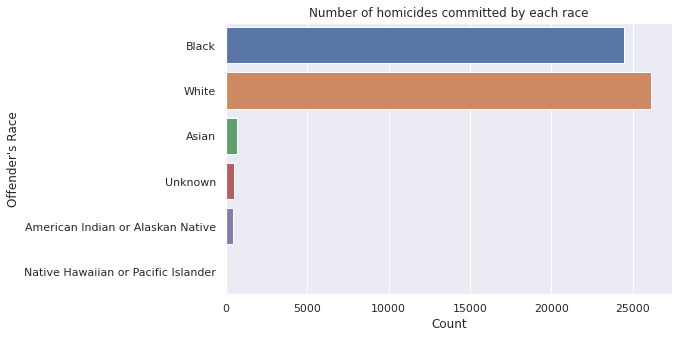

In [110]:
sns.set(rc = {'figure.figsize':(8, 5)})
sns.countplot(y=df['OffRace'])
plt.title('Number of homicides committed by each race')
plt.xlabel('Count')
plt.ylabel("Offender's Race");

From this graph, we can understand that the most murders are comitted by the people of race 'White' and 'Black. There is also a lot of 'Unknown' values. We will adjust these values later.

## **Initial Preprocessing and Cleaning**

Columns that are no longer required for our project are being removed. Further research reveals that these columns are always useful, but they are not required for the more specific features that we wish to focus on.

In [111]:
df.drop(['CNTYFIPS', 'Ori', 'Agency', 'Agentype', 'Source', 'StateName', 'ActionType', 'Situation', 'VicEthnic', 'OffEthnic', 'Circumstance', 'Subcircum', 
         'VicCount', 'OffCount', 'FileDate', 'MSA'], axis=1, inplace=True)

We will now replace all 'Unknown' and irrelevant variables with NA.

In [112]:
df.replace("other", np.nan, inplace=True)
df.replace("PAPSP8", np.nan, inplace=True)
df.replace("Unknown", np.nan, inplace=True)
df.replace("Other or type unknown", np.nan, inplace=True)
df.replace("Relationship not determined", np.nan, inplace=True)
df.replace(0, np.nan, inplace=True)

Plotting the NA values might also be beneficial. We can observe where the majority of these values are located in our dataset.

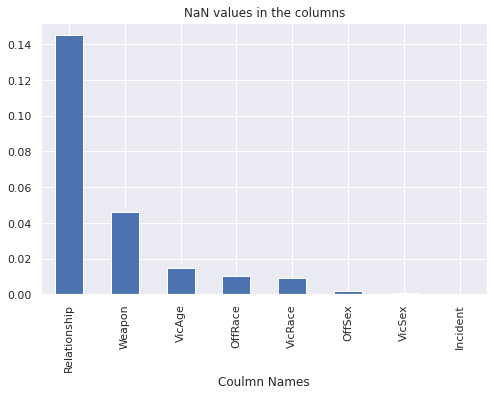

In [113]:
na_frac = df.isna().mean().sort_values(ascending=False)
na_frac[na_frac > 0.0].round(3).plot.bar()
plt.title('NaN values in the columns')
plt.xlabel('Coulmn Names')
plt.ylabel('');

We may deduce from this bar graph that the vast majority of NA values are in the 'Relationships' column, followed by 'OffRace' and 'OffSex'. We'll take care of everything down below.

We will now drop the NA values.

In [114]:
df.dropna(inplace=True)
df.shape

(41589, 15)

Changing the datatype of the numerical columns from float to int.

In [115]:
df['Incident'] = df['Incident'].apply(np.int64)

df['VicAge'] = df['VicAge'].apply(np.int64)

df['OffAge'] = df['OffAge'].apply(np.int64)

We will only evaluate homicides where the offender is between the ages of 18 and 70, and we will disregard the other rows. This is because we intend to concentrate on the major age groups.

In [116]:
sel_age = df.index[(df['OffAge'] < 18) | (df['OffAge'] > 70)]

df = df.drop(sel_age)

df.shape

(40025, 15)

Because there are so many different unique values, we'll combine the ones that are similar, together to make it easier to utilize. We intend to categorize the states together depending on the region they belong to. 

In [117]:
Weap_dict = {'Handgun - pistol, revolver, etc':'Firearm', 'Firearm, type not stated':'Firearm', 'Rifle':'Firearm', 'Shotgun':'Firearm', 'Other gun':'Firearm', 
             'Poison - does not include gas':'Other', 'Narcotics or drugs, sleeping pills':'Other', 'Knife or cutting instrument':'Cutting instrument',
             'Blunt object - hammer, club, etc':'Blunt object', 'Asphyxiation - includes death by gas':'Asphyxiation', 'Drowning':'Asphyxiation', 
             'Strangulation - hanging':'Asphyxiation', 'Personal weapons, includes beating':'Physical violence', 'Pushed or thrown out window':'Physical violence',
             'Explosives':'Other', 'Fire':'Other'}
df = df.replace({'Weapon': Weap_dict})

Rel_dict = {'Other - known to victim':'Acquaintance/friend', 'Brother':'Sibling', 'Sister':'Sibling', 'Father':'Parent', 'Mother':'Parent', 'Stepfather':'Parent', 
            'Stepmother':'Parent', 'Husband':'Spouse', 'Wife':'Spouse', 'Son':'Offspring', 'Daughter':'Offspring', 'Ex-husband':'Ex-spouse', 
            'Ex-wife':'Ex-spouse', 'In-law':'Other family', 'Common-law husband':'Spouse', 'Common-law wife':'Spouse', 'Stepson':'Offspring', 
            'Stepdaughter':'Offspring', 'Boyfriend':'Significant other', 'Girlfriend':'Significant other' , 'Homosexual relationship':'Significant other',
            'Employer': 'Coworker', 'Employee': 'Coworker', 'Acquaintance':'Acquaintance/friend', 'Friend':'Acquaintance/friend', 'Neighbor':'Acquaintance/friend'}
df = df.replace({'Relationship': Rel_dict})

State_dict = {'Alaska':'West', 'Hawaii':'West','California':'West', 'Oregon':'West', 'Washington':'West', 'Colorado':'West', 'Nevada':'West', 'Utah':'West', 'Wyoming':'West',
              'Idaho':'West', 'Montana':'West', 'North Dakota':'Midwest', 'South Dakota':'Midwest', 'Nebraska':'Midwest', 'Kansas':'Midwest', 'Missouri':'Midwest',
              'Iowa':'Midwest', 'Minnesota':'Midwest', 'Michigan':'Midwest','Wisconsin':'Midwest','Illinois':'Midwest','Indiana':'Midwest','Ohio':'Midwest', 
              'Arizona':'Southwest','New Mexico':'Southwest', 'Texas':'Southwest', 'Oklahoma':'Southwest', 'Delaware':'Southeast', 'Maryland':'Southeast', 
              'District of Columbia':'Southeast', 'West Virginia':'Southeast', 'Virginia':'Southeast', 'Kentucky':'Southeast', 'Tennessee':'Southeast', 
              'North Carolina':'Southeast', 'South Carolina':'Southeast', 'Georgia':'Southeast', 'Alabama':'Southeast', 'Mississippi':'Southeast', 'Arkansas':'Southeast', 
              'Florida':'Southeast', 'Louisiana':'Southeast', 'Maine':'Northeast', 'New Hampshire':'Northeast', 'Vermont':'Northeast', 'Massachusetts':'Northeast', 
              'Rhodes Island':'Northeast', 'New Jersey':'Northeast', 'New York':'Northeast', 'Pennsylvania':'Northeast', 'Connecticut':'Northeast'}
df = df.replace({'State': State_dict})

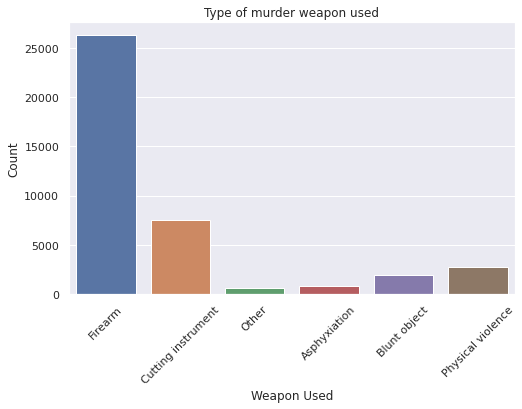

In [118]:
ax = sns.countplot(df['Weapon'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.title('Type of murder weapon used')
plt.xlabel('Weapon Used')
plt.ylabel('Count');

According to the graph above, the most commonly utilized weapon is a firearm, followed by a cutting tool and physical violence.

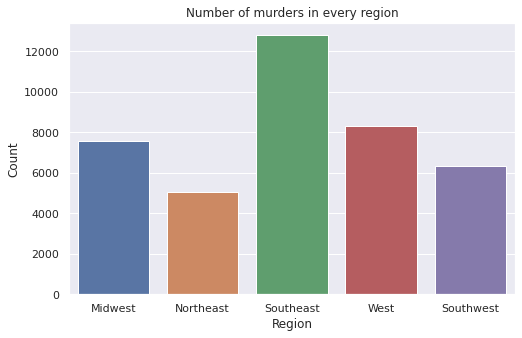

In [119]:
ax = sns.countplot(df['State'])
plt.title('Number of murders in every region')
plt.xlabel('Region')
plt.ylabel('Count');

Based on this figure, we may deduce that the Southeast region of the United States has had the most homicides, while the Northeast has had the fewest.

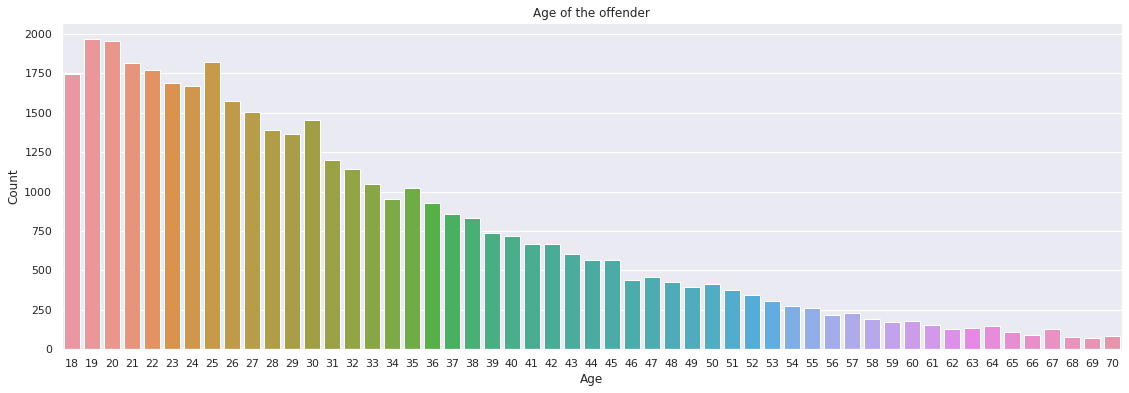

In [120]:
sns.set(rc = {'figure.figsize':(19, 6)})
sns.countplot(df['OffAge'])
plt.title('Age of the offender')
plt.xlabel('Age')
plt.ylabel('Count');

With aging, the number of offernders decreases. The majority of offenders are under the age of 40. The most offenders are between the ages of 19 and 23, which is not surprising.

## **Exploration and Visualisation**

From the visualization above we are able to see the basic structure of our dataset. We explored a few variables but our search requires us to dig a little deeper.

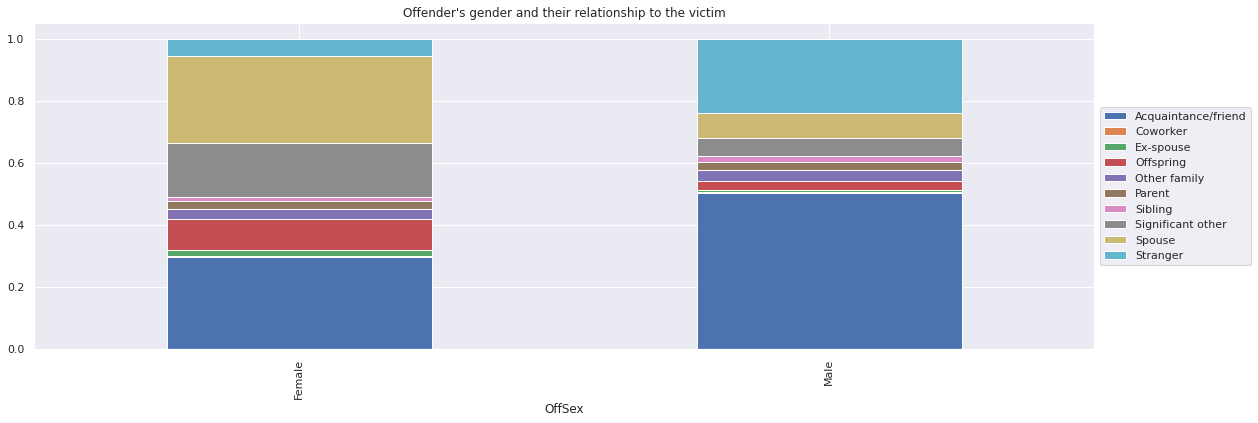

In [121]:
tbl = pd.crosstab(df['OffSex'], df['Relationship'], normalize='index')
tbl.plot.bar(stacked=True)
plt.title("Offender's gender and their relationship to the victim")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

This graph demonstrates that the majority of male offenders are either acquaintances/friends of the victim or strangers, but the majority of female offenders are a significant other or a spouse, as well as acquaintances/friends of the victim. The peculiar thing is that in the instance of female offenders, the offspring committed a significant proportion of homicides.

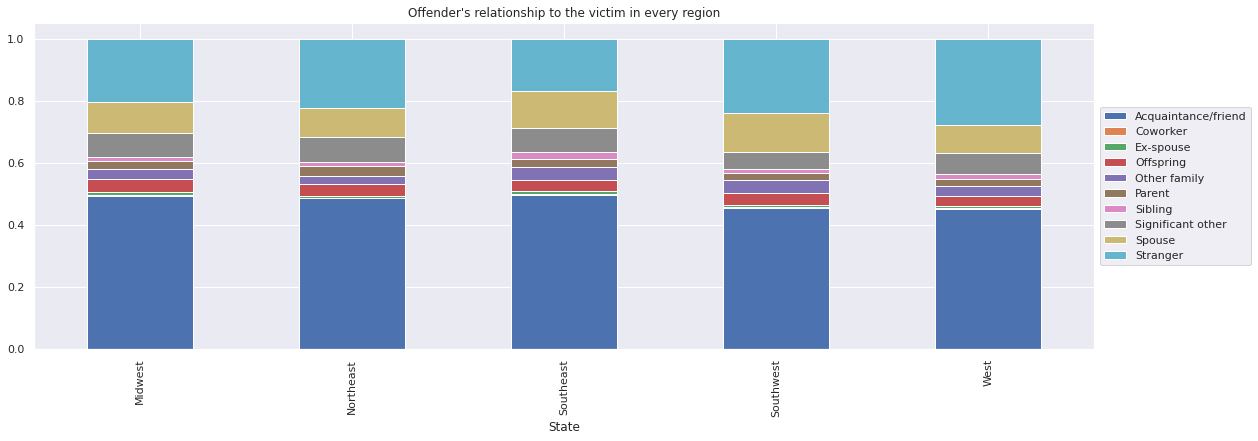

In [122]:
tbl = pd.crosstab(df['State'], df['Relationship'], normalize='index')
tbl.plot.bar(stacked=True)
plt.title("Offender's relationship to the victim in every region")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

This graph demonstrates how, in almost every location, the most significant offender is a victim's acquaintance or friend and then a stranger and a spouse.

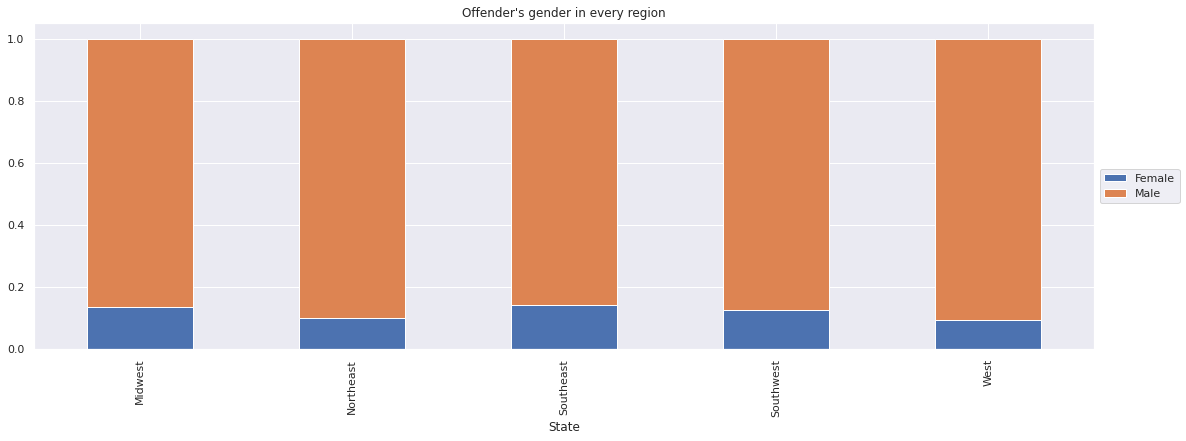

In [123]:
tbl = pd.crosstab(df['State'], df['OffSex'], normalize='index')
tbl.plot.bar(stacked=True)
plt.title("Offender's gender in every region")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

This graph demonstrates that the majority of offenders are men, despite the region.

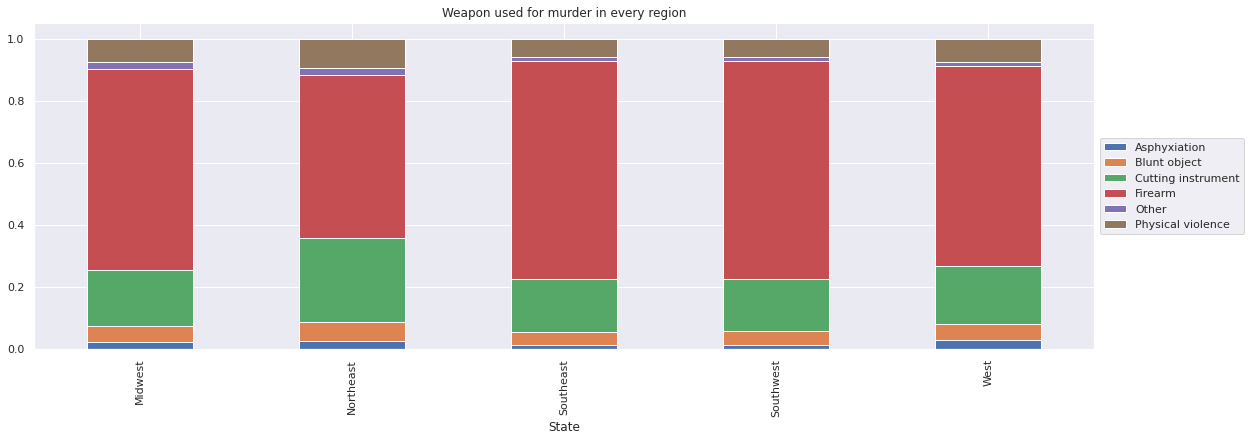

In [124]:
tbl = pd.crosstab(df['State'], df['Weapon'], normalize='index')
tbl.plot.bar(stacked=True)
plt.title('Weapon used for murder in every region')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

According to the graph above, in every state, the most commonly utilized weapon is a firearm, followed by a cutting tool and physical violence. The northeast has a high number of murders by cutting instruments than the other regions.

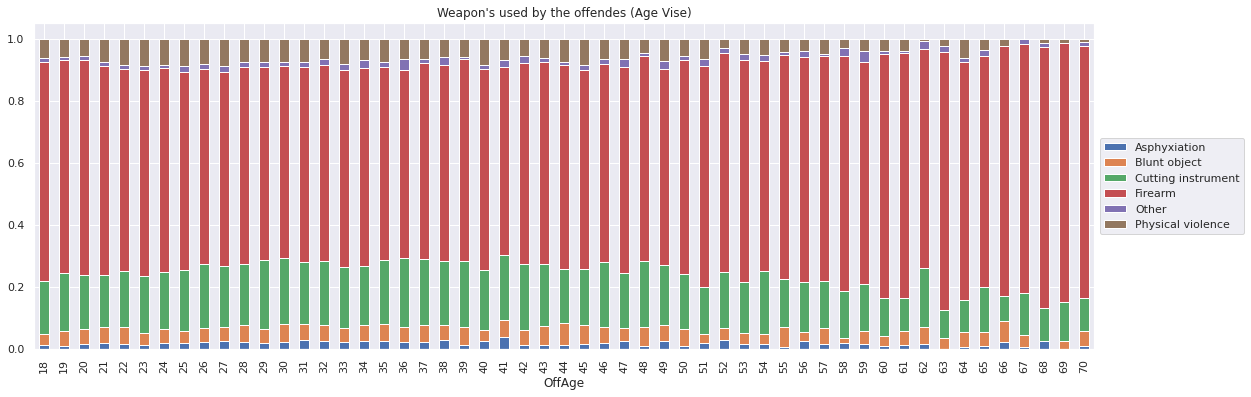

In [125]:
tbl = pd.crosstab(df['OffAge'], df['Weapon'], normalize='index')
tbl.plot.bar(stacked=True)
plt.title("Weapon's used by the offendes (Age Vise)")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

Despite its antiquity, this graph shows that firearms are the most often used weapon in the United States. The strange thing about this graph is how many murders are committed as a result of physical violence even in people beyond the age of 60!

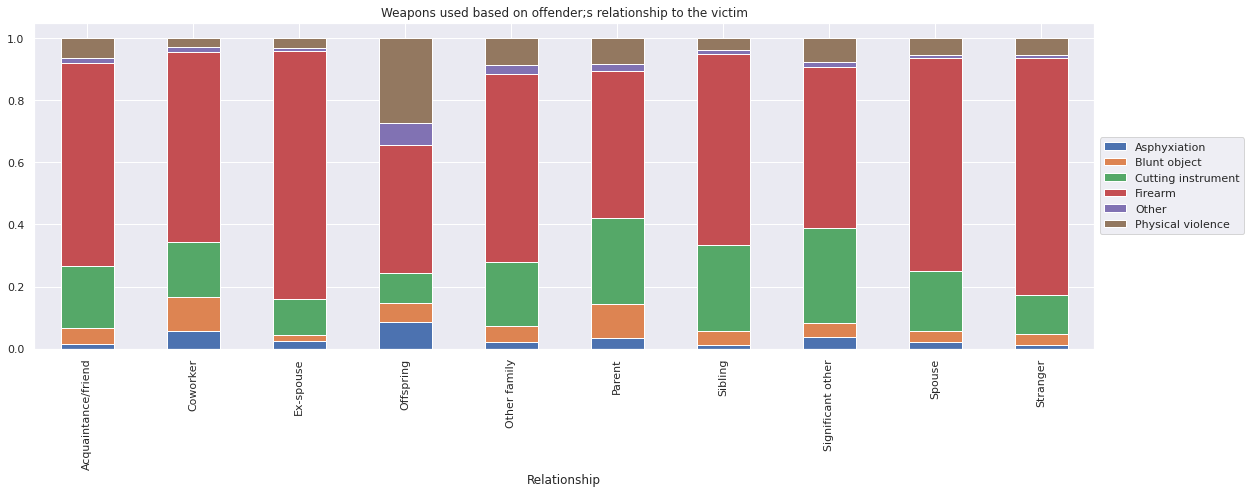

In [126]:
tbl = pd.crosstab(df['Relationship'], df['Weapon'], normalize='index')
tbl.plot.bar(stacked=True)
plt.title("Weapons used based on offender;s relationship to the victim")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

Observe how, with the exception of firearms, homicides committed by the victim's children are primarily the result of physical violence.

## **Machine Learning**

### Preparing data

In [127]:
np.random.seed(123)

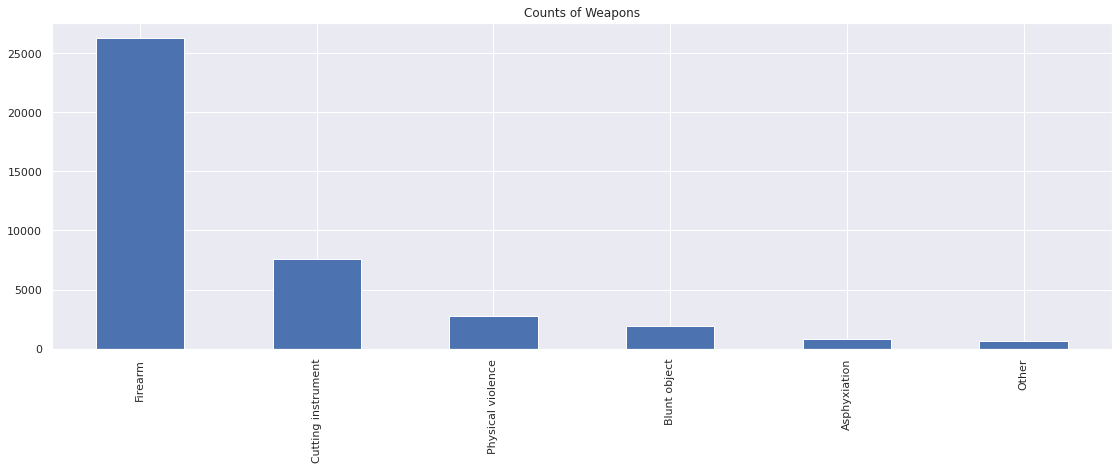

In [128]:
df['Weapon'].value_counts().plot.bar()
plt.title('Counts of Weapons');

The target value will be 'Weapon", however its class values aren't balanced. In order to make it more balanced we will first reduce the number of categories by ignorning and combining some of them. 

In [129]:
df.replace('Other', np.nan, inplace=True)
df.dropna(inplace=True)
Weap_dict = {'Asphyxiation': 'Asphyxiation/physical violence',  'Physical violence': 'Asphyxiation/physical violence' }
df = df.replace({'Weapon': Weap_dict})

Since the target variable is cateorgical we will encode it's categories using the ordinal encoding method. We will also encode the categorical predictor variables using the dummy variable method.

 

In [130]:
Weapon_dict = {'Firearm': 0, 'Cutting instrument': 1, 'Blunt object': 3, 'Asphyxiation/physical violence': 2}
df = df.replace({'Weapon':Weapon_dict})
df = pd.get_dummies(df, columns=['State'], drop_first=False)
df = pd.get_dummies(df, columns=['Relationship'], drop_first=False)

To futher balance the target variable we will oversample the minority classes.

In [131]:
majority_rows = df[df['Weapon'] == 0]
majority_count = majority_rows.shape[0]
minority_rows = df[(df['Weapon'] == 1) | (df['Weapon'] == 2) | (df['Weapon'] == 3)].sample(majority_count,replace=True)

df_balanced = pd.concat([majority_rows, minority_rows])
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

Converting the selected target and predictor variables to NumPy arrays.

In [132]:
predictors = ['OffAge','State_Northeast', 'State_Southeast', 'State_Southwest', 'State_West', 'State_Midwest', 'Relationship_Acquaintance/friend', 'Relationship_Coworker', 
              'Relationship_Ex-spouse', 'Relationship_Offspring', 'Relationship_Other family', 'Relationship_Parent', 'Relationship_Sibling', 
              'Relationship_Significant other', 'Relationship_Spouse', 'Relationship_Stranger']
target = 'Weapon'
X = df_balanced[predictors].values
y = df_balanced[target].values

Performing the 'Train/Test Split'

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape)
print(y_train.shape)

(36782, 16)
(36782,)


Before we apply an algorithm we will compute the baseline accuracy. This will be calculated using the most common weapon which is a firearm that was set to be 0.

In [134]:
accuracy = (0 == y).mean()
print('Baseline accuracy: {:.3f}'.format(accuracy))

Baseline accuracy: 0.500


### Logistic Regression

First, we are using Logistic Regression to make predictions about the murder weapon.

Fitting the classification model

In [95]:
clf = LogisticRegression(max_iter=1500)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1500)

In [96]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Cross-validation accuracy: {:.3f}'.format(scores.mean()))

Cross-validation accuracy: 0.524


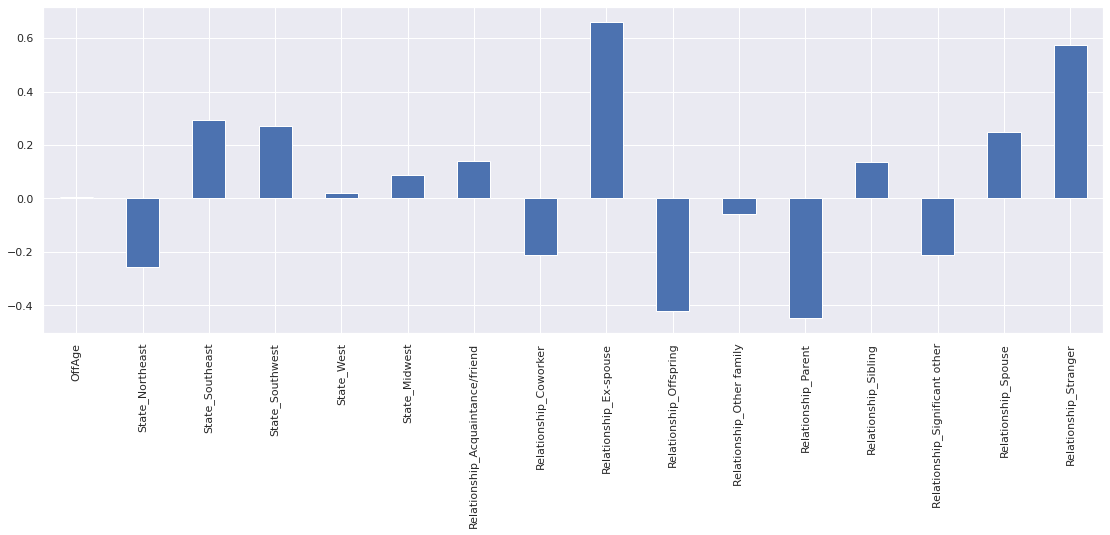

In [97]:
pd.Series(clf.coef_[0], index=predictors).plot.bar();

An Ex-spouse and a stranger seem to be significant in the choice of weapon used by the offender. The offenders age has a coefficeint of 0, which is suprising to us.

In [98]:
def plot_learning_curve(train_sizes, train_scores, test_scores):
  train_scores_mean = np.mean(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  plt.plot(train_sizes, train_scores_mean, label='train')
  plt.plot(train_sizes, test_scores_mean, label='test')
  plt.xlabel('training set size')
  plt.ylabel('accuracy')
  plt.title('Learning curve')
  plt.legend();

Plotting the learing curve

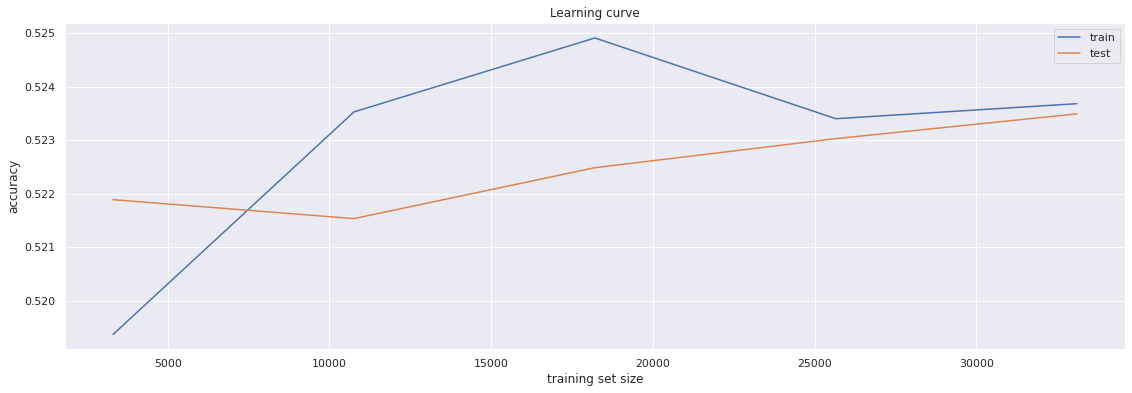

In [135]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
plot_learning_curve(train_sizes, train_scores, test_scores)

Getting the Test Accuracy

In [136]:
score = clf.score(X_test, y_test)
print('Test accuracy: {:.3f}'.format(score))

Test accuracy: 0.531


### Decision Tree Classifier

We will now use Decision Tree Classifier as our next algorithm to predict the weapon.

Fitting the classication model

In [137]:
clf = DecisionTreeClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

Predicting based on the test data

In [138]:
y_predict = clf.predict(X_test)

Getting the cross validation accuracy

In [139]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Cross-validation accuracy: {:.3f}'.format(scores.mean()))

Cross-validation accuracy: 0.512


Plotting the learing curve

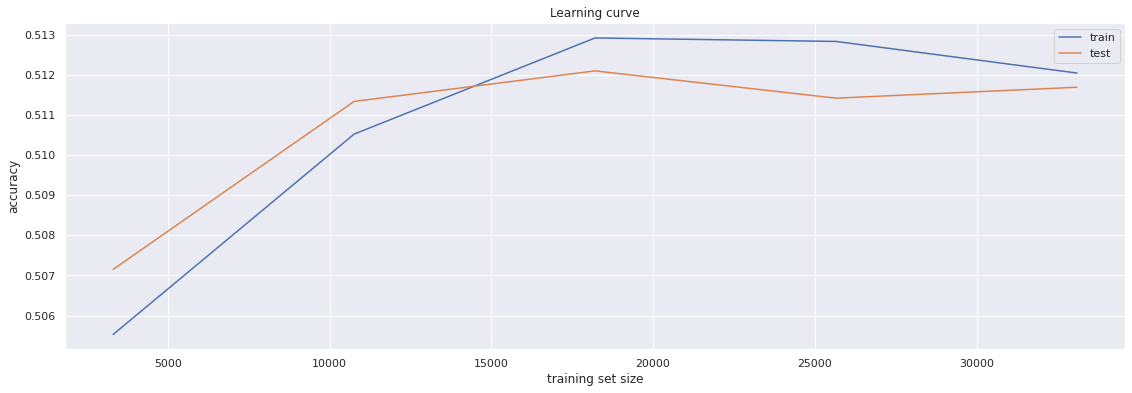

In [140]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
plot_learning_curve(train_sizes, train_scores, test_scores)

Getting the Test Accuracy 

In [141]:
score = clf.score(X_test, y_test)
print('Test accuracy: {:.3f}'.format(score))

Test accuracy: 0.522


Plotting a classification tree

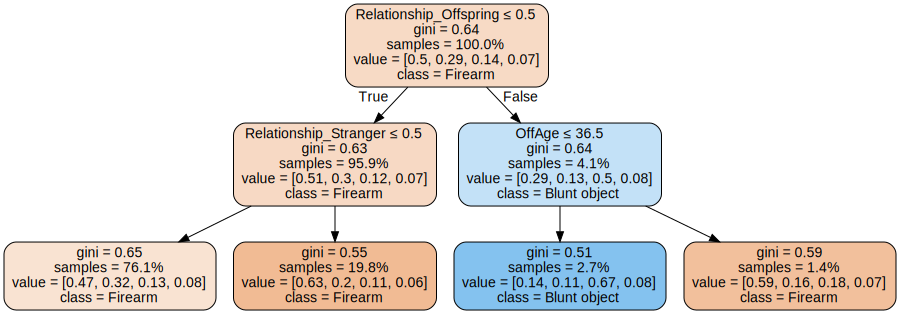

In [142]:
target_names = ['Firearm', 'Cutting instrument', 'Blunt object', 'Asphyxiation/physical violence']
dot_data = export_graphviz(clf, precision=2, feature_names=predictors, proportion=True, class_names=target_names, filled=True, rounded=True, special_characters=True)

#Plotting
graph = graphviz.Source(dot_data)
graph

## Conclusion

We discovered that the most prevalent weapon used for murder is a firearm, followed by a cutting device, in our study of Murder Accountability statistics in the United States from 1976 to 2020. There is no specific cause for this, however it is most likely owing to its ease of availability. We did, however, discover some intriguing data concerning the victim-offender relationship. The majority of these murders have been undertaken by a victim's acquaintance or a friend, which is rather frightening. Another finding revealed that the most prevalent age group for murderers is in their twenties.

We utilized the US Murder Accountability dataset to forecast the murder weapon based on the offender's age, the location of the murder in the United States, and the connection between the offender and victim. We utilized logistic regression and a decision tree classifier as methods. We were able to predict the weapon with a 51% accuracy using logistic regression. This is marginally greater than the baseline accuracy of 50%. The accuracy of the decision tree classifier, on the other hand, was 52%. If we were to dig a bit deeper into the murder weapon, we would look at the individual states. As a result, the sampling would be smaller and maybe more accurate by state.